In [1]:
!pip install swig --quiet
!pip install "gymnasium[box2d]" --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [15]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import animation
from PIL import Image
import warnings

warnings.filterwarnings('ignore')

# Параметры среды
ENV_NAME = "CarRacing-v3"
# ENV_NAME = "CarRacing-v2"
STATE_SHAPE = (3, 96, 96)  # Изображение 96x96 RGB
ACTION_SIZE = 3  # Непрерывные действия: [руление, газ, торможение]

# Параметры обучения
LEARNING_RATE = 3e-4
GAMMA = 0.99
ENTROPY_COEF = 0.05
VALUE_COEF = 0.5
MAX_EPISODES = 150
MAX_STEPS = 1000
BATCH_SIZE = 128
UPDATE_EVERY = 10
SAVE_EVERY = 100
SEED = 42
CLIP_GRAD = 0.5  # Клиппинг градиентов

# Пути для сохранения
MODEL_DIR = "continuous_a2c_models"
os.makedirs(MODEL_DIR, exist_ok=True)

# Установка seed для воспроизводимости
torch.manual_seed(SEED)
np.random.seed(SEED)

# Предобработка состояния (изображения)
def preprocess_state(state):
    state = state.transpose(2, 0, 1)  # Из HWC в CHW
    state = state / 255.0  # Нормализация
    return state

# Архитектура сети Actor-Critic для непрерывных действий
class ContinuousActorCritic(nn.Module):
    def __init__(self, state_shape, action_size):
        super(ContinuousActorCritic, self).__init__()

        # Общая часть сети для извлечения признаков
        self.conv1 = nn.Conv2d(state_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Полносвязные слои
        self.fc1 = nn.Linear(self._get_conv_output(state_shape), 512)

        # Ветка актера (политика)
        self.actor_fc = nn.Linear(512, 256)
        self.actor_mu = nn.Linear(256, action_size)
        self.actor_log_std = nn.Parameter(torch.zeros(1, action_size))  # Логарифм стандартного отклонения

        # Ветка критика (значение состояния)
        self.critic_fc = nn.Linear(512, 256)
        self.critic_out = nn.Linear(256, 1)

        # Инициализация весов
        self._initialize_weights()

    def _get_conv_output(self, shape):
        with torch.no_grad():
            x = torch.zeros(1, *shape)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = F.relu(self.conv3(x))
            return int(np.prod(x.size()[1:]))

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.orthogonal_(module.weight, np.sqrt(2))
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        # Извлечение признаков
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Вытягиваем в вектор

        # Общие полносвязные слои
        x = F.relu(self.fc1(x))

        # Ветка актера
        actor_x = F.relu(self.actor_fc(x))
        mu = self.actor_mu(actor_x)

        # Применяем разные активации для разных действий
        mu[:, 0] = torch.tanh(mu[:, 0])  # Руление в [-1, 1]
        mu[:, 1:] = torch.sigmoid(mu[:, 1:])  # Газ и торможение в [0, 1]

        # Стандартное отклонение
        sigma = torch.exp(self.actor_log_std).expand_as(mu)

        # Ветка критика
        critic_x = F.relu(self.critic_fc(x))
        value = self.critic_out(critic_x)

        return mu, sigma, value

    def act(self, state):
        with torch.no_grad():
            mu, sigma, value = self.forward(state)
            dist = Normal(mu, sigma)
            action = dist.sample()
            log_prob = dist.log_prob(action).sum(-1, keepdim=True)

            # Ограничиваем действия (хотя это уже сделано через активации)
            action[:, 0] = torch.clamp(action[:, 0], -1, 1)  # Руление
            action[:, 1:] = torch.clamp(action[:, 1:], 0, 1)  # Газ и торможение

            return action.cpu().numpy()[0], log_prob.item(), value.item()

# Агент A2C для непрерывных действий
class ContinuousA2CAgent:
    def __init__(self, state_shape, action_size):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = ContinuousActorCritic(state_shape, action_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.action_size = action_size

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        return self.model.act(state)

    def compute_loss(self, batch):
        states = torch.FloatTensor(np.array(batch['states'])).to(self.device)
        actions = torch.FloatTensor(np.array(batch['actions'])).to(self.device)
        log_probs = torch.FloatTensor(np.array(batch['log_probs'])).unsqueeze(1).to(self.device)
        values = torch.FloatTensor(np.array(batch['values'])).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(np.array(batch['rewards'])).unsqueeze(1).to(self.device)
        next_values = torch.FloatTensor(np.array(batch['next_values'])).unsqueeze(1).to(self.device)
        dones = torch.FloatTensor(np.array(batch['dones'])).unsqueeze(1).to(self.device)

        # Вычисляем advantage
        advantages = rewards + GAMMA * next_values * (1 - dones) - values

        # Вычисляем целевые значения
        target_values = rewards + GAMMA * next_values * (1 - dones)

        # Обновляем модель
        mu, sigma, current_values = self.model(states)
        dist = Normal(mu, sigma)
        entropy = dist.entropy().mean()

        # Потери актера
        new_log_probs = dist.log_prob(actions).sum(-1, keepdim=True)
        actor_loss = -(new_log_probs * advantages.detach()).mean() - ENTROPY_COEF * entropy

        # Потери критика
        critic_loss = VALUE_COEF * F.mse_loss(current_values, target_values.detach())

        # Общие потери
        total_loss = actor_loss + critic_loss

        return total_loss

    def update(self, batch, episode):
        loss = self.compute_loss(batch)

        self.optimizer.zero_grad()
        loss.backward()
        clip_grad = CLIP_GRAD/2**(episode//10)

        torch.nn.utils.clip_grad_norm_(self.model.parameters(), clip_grad)
        self.optimizer.step()

        return loss.item()

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path))
        self.model.eval()

# Функция для обучения
def train():
    env = gym.make(ENV_NAME, continuous=True)  # Используем непрерывные действия
    state_shape = STATE_SHAPE
    action_size = ACTION_SIZE

    agent = ContinuousA2CAgent(state_shape, action_size)
    rewards_history = []
    avg_rewards = []
    recent_rewards = deque(maxlen=100)

    for episode in range(1, MAX_EPISODES + 1):
        state, _ = env.reset()
        state = preprocess_state(state)
        total_reward = 0
        batch = {
            'states': [],
            'actions': [],
            'log_probs': [],
            'values': [],
            'rewards': [],
            'next_values': [],
            'dones': []
        }

        for step in range(1, MAX_STEPS + 1):
            # Получаем действие от агента
            action, log_prob, value = agent.get_action(state)

            # Выполняем действие в среде
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = preprocess_state(next_state)

            # Сохраняем переход
            _, _, next_value = agent.get_action(next_state)

            batch['states'].append(state)
            batch['actions'].append(action)
            batch['log_probs'].append(log_prob)
            batch['values'].append(value)
            batch['rewards'].append(reward)
            batch['next_values'].append(next_value)
            batch['dones'].append(done)

            total_reward += reward
            state = next_state

            # Обновляем модель
            if step % UPDATE_EVERY == 0 or done:
                if len(batch['states']) > 0:
                    loss = agent.update(batch, episode)
                    batch = {
                        'states': [],
                        'actions': [],
                        'log_probs': [],
                        'values': [],
                        'rewards': [],
                        'next_values': [],
                        'dones': []
                    }

            if done:
                break

        # Сохраняем результаты
        rewards_history.append(total_reward)
        recent_rewards.append(total_reward)
        avg_reward = np.mean(recent_rewards)
        avg_rewards.append(avg_reward)

        print(f"Episode: {episode}, Reward: {total_reward:.2f}, Avg Reward (last 100): {avg_reward:.2f}")

        # Сохраняем модель
        if episode % SAVE_EVERY == 0:
            agent.save_model(f"{MODEL_DIR}/continuous_a2c_{ENV_NAME}_ep{episode}.pth")

    # Сохраняем графики
    plt.figure(figsize=(12, 6))
    plt.plot(rewards_history, label='Reward per episode', alpha=0.5)
    plt.plot(avg_rewards, label='Avg reward (last 100)', color='red', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Continuous A2C Training Progress in CarRacing-v2')
    plt.legend()
    plt.grid()
    plt.savefig(f"{MODEL_DIR}/continuous_training_plot.png")
    plt.show()

    env.close()

    return rewards_history, avg_rewards

Episode: 1, Reward: -73.51, Avg Reward (last 100): -73.51
Episode: 2, Reward: -75.76, Avg Reward (last 100): -74.63
Episode: 3, Reward: -71.25, Avg Reward (last 100): -73.50
Episode: 4, Reward: -73.33, Avg Reward (last 100): -73.46
Episode: 5, Reward: -70.20, Avg Reward (last 100): -72.81
Episode: 6, Reward: -70.30, Avg Reward (last 100): -72.39
Episode: 7, Reward: -69.59, Avg Reward (last 100): -71.99
Episode: 8, Reward: -69.39, Avg Reward (last 100): -71.67
Episode: 9, Reward: -76.32, Avg Reward (last 100): -72.18
Episode: 10, Reward: -68.75, Avg Reward (last 100): -71.84
Episode: 11, Reward: -71.61, Avg Reward (last 100): -71.82
Episode: 12, Reward: -66.04, Avg Reward (last 100): -71.34
Episode: 13, Reward: -67.27, Avg Reward (last 100): -71.02
Episode: 14, Reward: -73.61, Avg Reward (last 100): -71.21
Episode: 15, Reward: -73.60, Avg Reward (last 100): -71.37
Episode: 16, Reward: -65.52, Avg Reward (last 100): -71.00
Episode: 17, Reward: -69.59, Avg Reward (last 100): -70.92
Episod

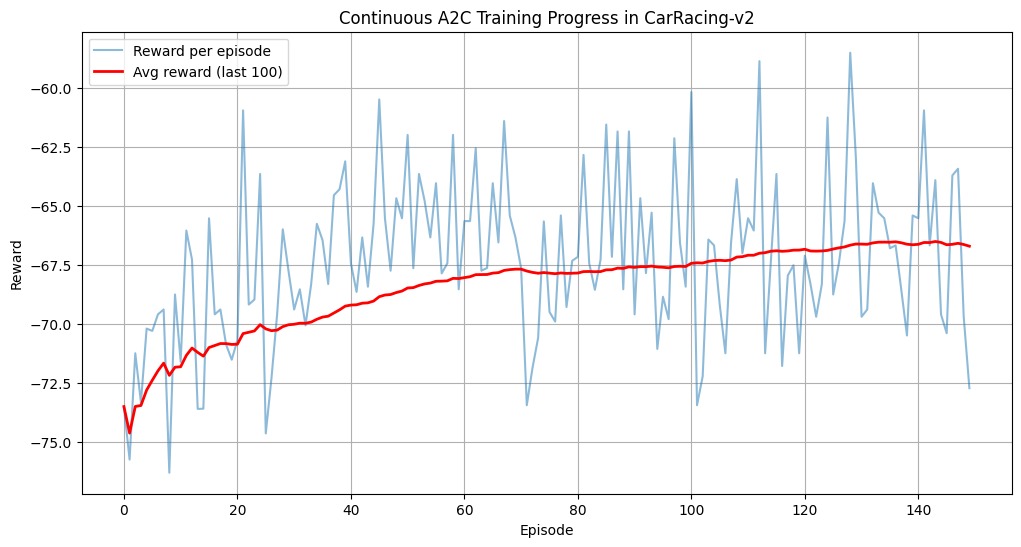

In [16]:
  rewards, avg_rewards = train()

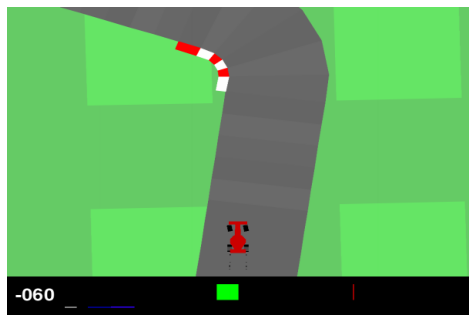

In [17]:
def select_action_trained(state):
  return agent.get_action(preprocess_state(state))[0]
  # return env.action_space.sample()


def run_episode(env):
    frames = []
    state, _ = env.reset()
    done = False

    while not done:
        frames.append(env.render())
        action = select_action_trained(state)
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    frames.append(env.render())
    return frames


def save_frames_as_gif(frames, path='./Car-Racing.gif'):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save(path, writer='pillow', fps=10)


state_shape = STATE_SHAPE
action_size = ACTION_SIZE
agent = ContinuousA2CAgent(state_shape, action_size)

env = gym.make(ENV_NAME, continuous=True, render_mode="rgb_array")

frames = run_episode(env)
save_frames_as_gif(frames, path=f'./Car-Racing.gif')